## Load data and perform cleaning and tabulation

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
param_alpha = 0.2
MAX_ALPHA = 0.5

# A_score_data_type
dataType ="unmitigated" 
# dataType = "threshold_opt"
# dataType ="Exponentiated_grad"

from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity

constraint = "equalized_odds"
const = EqualizedOdds()

# constraint = "demographic_parity"
# const = DemographicParity()



In [3]:
from urllib.request import urlretrieve
urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', 'german.data')

('german.data', <http.client.HTTPMessage at 0x7fa64696c670>)

In [4]:
german_df = pd.read_csv('german.data', 
                        delimiter=' ',header=None)

In [5]:
german_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
 2   2       1000 non-null   object
 3   3       1000 non-null   object
 4   4       1000 non-null   int64 
 5   5       1000 non-null   object
 6   6       1000 non-null   object
 7   7       1000 non-null   int64 
 8   8       1000 non-null   object
 9   9       1000 non-null   object
 10  10      1000 non-null   int64 
 11  11      1000 non-null   object
 12  12      1000 non-null   int64 
 13  13      1000 non-null   object
 14  14      1000 non-null   object
 15  15      1000 non-null   int64 
 16  16      1000 non-null   object
 17  17      1000 non-null   int64 
 18  18      1000 non-null   object
 19  19      1000 non-null   object
 20  20      1000 non-null   int64 
dtypes: int64(8), object(13)
memory usage: 164.2+ KB


In [6]:
urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc', 'german.doc')
f = open('german.doc')
german_doc= f.read()
print(german_doc)

Description of the German credit dataset.

1. Title: German Credit data

2. Source Information

Professor Dr. Hans Hofmann  
Institut f"ur Statistik und "Okonometrie  
Universit"at Hamburg  
FB Wirtschaftswissenschaften  
Von-Melle-Park 5    
2000 Hamburg 13 

3. Number of Instances:  1000

Two datasets are provided.  the original dataset, in the form provided
by Prof. Hofmann, contains categorical/symbolic attributes and
is in the file "german.data".   
 
For algorithms that need numerical attributes, Strathclyde University 
produced the file "german.data-numeric".  This file has been edited 
and several indicator variables added to make it suitable for 
algorithms which cannot cope with categorical variables.   Several
attributes that are ordered categorical (such as attribute 17) have
been coded as integer.    This was the form used by StatLog.


6. Number of Attributes german: 20 (7 numerical, 13 categorical)
   Number of Attributes german.numer: 24 (24 numerical)


7.  Attribute d

In [7]:
# rename columns 
german_df.columns=['account_bal','duration','payment_status','purpose',
                   'credit_amount','savings_bond_value','employed_since',
                   'intallment_rate','sex_marital','guarantor','residence_since',
                   'most_valuable_asset','age','concurrent_credits','type_of_housing',
                   'number_of_existcr','job','number_of_dependents','telephon',
                   'foreign','target']

In [8]:
# find and replace particular values
german_df= german_df.replace(['A11','A12','A13','A14', 'A171','A172','A173','A174','A121','A122','A123','A124'],
                  ['neg_bal','positive_bal','positive_bal','no_acc','unskilled','unskilled','skilled','highly_skilled',
                   'none','car','life_insurance','real_estate'])

In [9]:
# separate out sex & marital status
german_df["sex"] = german_df["sex_marital"]
german_df["sex"] = german_df["sex"].map({ "A91":"Male", 
                      "A93":"Male",
                      "A94":"Male",
                      "A92":"Female",
                      "A95":"Female"
                     })

In [10]:
german_df.rename(columns={"sex_marital": 'marital', 'oldName2': 'newName2'}, inplace=True)
# german_df["marital"] = german_df["marital"].map({ "A91" : "divorced/separated",
#                                                  "A92" : "divorced/separated/married",
#                                                  "A93" : "single",
#                                                  "A94" : "married/widowed",
#                                                  "A95" : "single"
#                                                 })
german_df["marital"] = german_df["marital"].map({ "A91" : "not_single",
                                                 "A92" : "not_single",
                                                 "A93" : "single",
                                                 "A94" : "not_single",
                                                 "A95" : "single"
                                                })


In [11]:
german_df.head()

,account_bal,duration,payment_status,purpose,credit_amount,savings_bond_value,employed_since,intallment_rate,marital,guarantor,...,age,concurrent_credits,type_of_housing,number_of_existcr,job,number_of_dependents,telephon,foreign,target,sex
0,neg_bal,6,A34,A43,1169,A65,A75,4,single,A101,...,67,A143,A152,2,skilled,1,A192,A201,1,Male
1,positive_bal,48,A32,A43,5951,A61,A73,2,not_single,A101,...,22,A143,A152,1,skilled,1,A191,A201,2,Female
2,no_acc,12,A34,A46,2096,A61,A74,2,single,A101,...,49,A143,A152,1,unskilled,2,A191,A201,1,Male
3,neg_bal,42,A32,A42,7882,A61,A74,2,single,A103,...,45,A143,A153,1,skilled,2,A191,A201,1,Male
4,neg_bal,24,A33,A40,4870,A61,A73,3,single,A101,...,53,A143,A153,2,skilled,2,A191,A201,2,Male


In [12]:
# Check for missing values in case
german_df.isna().any().any()

False

## Fix Target columns --> '0': Good Loan & '1': Bad Loan


In [13]:
# The target column has two values:
# 1: represents a good loan
# 2: represents a bad (defaulted) loan.
print(german_df.target.unique())

### FIX THE TARGET COLUMNS ###
# The usual convention is to use '1' for bad loans and '0' for good loans. 

from sklearn.preprocessing import LabelEncoder

labEn= LabelEncoder()
labEn.fit(german_df.target)
german_df.target=labEn.transform(german_df.target)



[1 2]


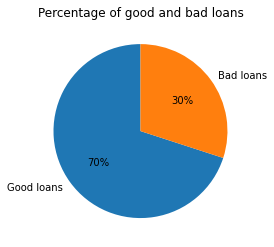

In [14]:
# visualize to see class imbalance
good_bad_per=round(((german_df.target.value_counts()/german_df.target.count())*100))
good_bad_per
plt.pie(good_bad_per,labels=['Good loans', 'Bad loans'], autopct='%1.0f%%', startangle=90)
plt.title('Percentage of good and bad loans');

In [15]:
german_df[['credit_amount','duration','age']].describe()

## credit amount is very large compared to the rest

,credit_amount,duration,age
count,1000.000000,1000.000000,1000.000000
mean,3271.258000,20.903000,35.546000
std,2822.736876,12.058814,11.375469
min,250.000000,4.000000,19.000000
25%,1365.500000,12.000000,27.000000
50%,2319.500000,18.000000,33.000000
75%,3972.250000,24.000000,42.000000
max,18424.000000,72.000000,75.000000


In [16]:
german_df['credit_amount'] = np.log(german_df['credit_amount']) # fix credit_amount
german_df[['credit_amount','duration','age']].describe()

,credit_amount,duration,age
count,1000.000000,1000.000000,1000.000000
mean,7.788691,20.903000,35.546000
std,0.776474,12.058814,11.375469
min,5.521461,4.000000,19.000000
25%,7.219276,12.000000,27.000000
50%,7.749107,18.000000,33.000000
75%,8.287088,24.000000,42.000000
max,9.821409,72.000000,75.000000


## encode categorical variables

In [17]:
# Number of unique classes in each object column
german_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

account_bal             3
payment_status          5
purpose                10
savings_bond_value      5
employed_since          5
marital                 2
guarantor               3
most_valuable_asset     4
concurrent_credits      3
type_of_housing         3
job                     3
telephon                2
foreign                 2
sex                     2
dtype: int64

### Implementation: <br>
- 2 catergories  label encoding
- greater that 2 categories One Hot

    

In [18]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in german_df:
    if german_df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(german_df[col].unique())) <= 2:
            # Train on the training data
            le.fit(german_df[col])
            # Transform both training and testing data
            german_df[col] = le.transform(german_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [19]:
# le.inverse_transform(german_df["sex"])

In [20]:
# german_df["sex"]

In [21]:
german_df = pd.get_dummies(german_df)

print('Encoded Features shape: ', german_df.shape)

Encoded Features shape:  (1000, 56)


## Prepare Train-Test

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x, y = german_df.drop('target', axis=1), german_df['target']
x.shape, y.shape

((1000, 55), (1000,))

In [24]:
X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=.2, random_state=42)

In [25]:
## extract sensitive features
A = X_test["sex"].map({1:"Male",0:"Female"})
A_str_test = X_test["sex"]
A_ = X_train["sex"].map({1:"Male",0:"Female"})
A_str_train = X_train["sex"]

In [26]:
import scipy.stats as ss

In [27]:
X_train.columns

Index(['duration', 'credit_amount', 'intallment_rate', 'marital',
       'residence_since', 'age', 'number_of_existcr', 'number_of_dependents',
       'telephon', 'foreign', 'sex', 'account_bal_neg_bal',
       'account_bal_no_acc', 'account_bal_positive_bal', 'payment_status_A30',
       'payment_status_A31', 'payment_status_A32', 'payment_status_A33',
       'payment_status_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410',
       'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45',
       'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_bond_value_A61',
       'savings_bond_value_A62', 'savings_bond_value_A63',
       'savings_bond_value_A64', 'savings_bond_value_A65',
       'employed_since_A71', 'employed_since_A72', 'employed_since_A73',
       'employed_since_A74', 'employed_since_A75', 'guarantor_A101',
       'guarantor_A102', 'guarantor_A103', 'most_valuable_asset_car',
       'most_valuable_asset_life_insurance', 'most_valuable_asset_none',
       'most_valuable

## LIGHTGBM Model for analysis


In [28]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'cross_entropy', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test

In [29]:
model.fit(train_data, train_labels)
# Scores on test set
test_scores = model.predict_proba(test_data)[:, 1]
test_pred = model.predict(test_data)

In [30]:
# Train AUC
roc_auc_score(train_labels, model.predict_proba(train_data)[:, 1])
# ACCURACY
accuracy_score(test_labels, test_pred)
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(train_labels)) * 1

Plot feature importance to visualize which features are most useful for prediction

In [31]:
# # LightGBM feature importance 
# lgb.plot_importance(model, figsize = (10,20), height=0.3, title="Features importance (LightGBM)", importance_type="gain", max_num_features=100) 
# plt.show()

In [32]:
# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)


In [33]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
#         "Demographic parity ratio": (
#             lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
#         "------": (lambda x: "", True),
#         "Overall balanced error rate": (
#             lambda x: 1-balanced_accuracy_score(y_true, x), True),
#         "Balanced error rate difference": (
#             lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
#         " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
#         "  ------": (lambda x: "", True),
#         "Overall AUC": (
#             lambda x: roc_auc_score(y_true, x), False),
        "Accuracy": (
             lambda x: accuracy_score(y_true, x), True),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [34]:
if dataType =="unmitigated" or dataType =="threshold_opt":
    postprocess_est = ThresholdOptimizer(
        estimator = model,
        constraints = constraint,
        prefit=True)

    balanced_idx1 = train_data[train_labels==1].index
    pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=124).index)
    df_train_balanced = train_data.loc[pp_train_idx, :]
    Y_train_balanced = train_labels.loc[pp_train_idx]
    A_train_balanced = A_.loc[pp_train_idx]


    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

    postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                   "EO_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                   "DP_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}

if dataType == "Exponentiated_grad":
    from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=10)
    xgc = XGBClassifier(verbosity=0)
    eg = ExponentiatedGradient(estimator= model, constraints = const ,max_iter=2)
    eg.fit(train_data,train_labels, sensitive_features=A_)
    eg_test_preds = eg.predict(test_data)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                  "EO_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                  "DP_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}    

table_init = get_metrics_df(models_dict, test_labels, A_str_test)

In [35]:
from ipynb.fs.full.GERMAN_DATA_FUNCTIONS import create_table
from ipynb.fs.full.GERMAN_DATA_FUNCTIONS import import_predef_funcs


valid_features = ['duration', 'credit_amount', 'intallment_rate', 'marital',
       'residence_since', 'age', 'number_of_existcr', 'number_of_dependents',
       'telephon', 'foreign', 'sex', 'account_bal_neg_bal',
       'account_bal_no_acc', 'account_bal_positive_bal', 'payment_status_A30',
       'payment_status_A31', 'payment_status_A32', 'payment_status_A33',
       'payment_status_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410',
       'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45',
       'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_bond_value_A61',
       'savings_bond_value_A62', 'savings_bond_value_A63',
       'savings_bond_value_A64', 'savings_bond_value_A65',
       'employed_since_A71', 'employed_since_A72', 'employed_since_A73',
       'employed_since_A74', 'employed_since_A75', 'guarantor_A101',
       'guarantor_A102', 'guarantor_A103', 'most_valuable_asset_car',
       'most_valuable_asset_life_insurance', 'most_valuable_asset_none',
       'most_valuable_asset_real_estate', 'concurrent_credits_A141',
       'concurrent_credits_A142', 'concurrent_credits_A143',
       'type_of_housing_A151', 'type_of_housing_A152', 'type_of_housing_A153',
       'job_highly_skilled', 'job_skilled', 'job_unskilled']
    

constraint = constraint
# table = pd.DataFrame() # already declared before for all features
table = table_init
for dr_feat in valid_features:
#     drop_val_f = valid_features
#     drop_val_f.remove(dr_feat) # drop one feature at a time from full list
    tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                  model,A,A_,A_str_train,A_str_test,
                  constraint,dr_feat,dataType)
#     print(tempo)
#     table = pd.concat(table,tempo)
    table = pd.concat([table, tempo], axis=1)
    
    
    

In [36]:
table 

,EO_Unmit:allFeat,EO_ThOpt:allFeat,EO_Unmit:duration,EO_ThOpt:duration,EO_Unmit:cred_amt,EO_ThOpt:cred_amt,EO_Unmit:instal_rate,EO_ThOpt:instal_rate,EO_Unmit:marital,EO_ThOpt:marital,...,EO_Unmit:house_A152,EO_ThOpt:house_A152,EO_Unmit:house_A153,EO_ThOpt:house_A153,EO_Unmit:highly_skilled,EO_ThOpt:highly_skilled,EO_Unmit:skilled,EO_ThOpt:skilled,EO_Unmit:unskilled,EO_ThOpt:unskilled
Overall selection rate,0.395000,0.230000,0.435000,0.210000,0.390000,0.235000,0.400000,0.215000,0.385000,0.200000,...,0.380000,0.240000,0.395000,0.250000,0.380000,0.250000,0.400000,0.210000,0.395000,0.210000
Demographic parity difference,0.027778,0.071429,0.040675,0.043651,0.003968,0.053571,0.014881,0.125000,0.038690,0.104167,...,0.081349,0.060516,0.002976,0.074405,0.006944,0.099206,0.014881,0.118056,0.027778,0.043651
False positive rate difference,0.001508,0.076169,0.064857,0.030920,0.027149,0.105581,0.027149,0.056561,0.001508,0.036953,...,0.085219,0.050528,0.001508,0.034691,0.030166,0.105581,0.027149,0.066365,0.001508,0.036953
False negative rate difference,0.114846,0.077031,0.032213,0.088235,0.067227,0.053221,0.032213,0.301120,0.149860,0.277311,...,0.091036,0.100840,0.032213,0.183473,0.026611,0.100840,0.032213,0.253501,0.114846,0.077031
Equalized odds difference,0.114846,0.077031,0.064857,0.088235,0.067227,0.105581,0.032213,0.301120,0.149860,0.277311,...,0.091036,0.100840,0.032213,0.183473,0.030166,0.105581,0.032213,0.253501,0.114846,0.077031
Accuracy,0.740000,0.785000,0.700000,0.775000,0.725000,0.760000,0.735000,0.790000,0.730000,0.795000,...,0.745000,0.785000,0.740000,0.775000,0.765000,0.775000,0.735000,0.775000,0.740000,0.805000
AUC difference,0.047529,0.000431,0.022068,0.028658,0.018602,0.079401,0.042986,0.122280,0.047457,0.120179,...,0.035714,0.025156,0.030076,0.074391,0.010127,0.002370,0.047422,0.093568,0.047529,0.020039


In [37]:
# table.iloc[:,np.arange(1,table.shape[1]+1,2)]

In [38]:
from ipynb.fs.full.GERMAN_DATA_FUNCTIONS import compute_Ascore

abbr_feat = {'duration':"duration", 'credit_amount':"cred_amt", 'intallment_rate':"instal_rate", 
             'residence_since':"res_since",'age':"age", 'number_of_existcr':"num_existcr", 
             'number_of_dependents':"num_dep", 'telephon':"telephon",'marital':"marital",
       'foreign':"foreign", 'sex':"sex", 'account_bal_neg_bal':"acct_neg_bal", 'account_bal_no_acc':"acct_no_acct",
       'account_bal_positive_bal':"acct_pos_bal", 
        'payment_status_A30':"pay_stat_A30", 'payment_status_A31':"pay_stat_A31",
       'payment_status_A32':"pay_stat_A32", 'payment_status_A33':"pay_stat_A33", 'payment_status_A34':"pay_stat_A34",
       'purpose_A40':"pur_A40", 'purpose_A41':"pur_A41", 'purpose_A410':"pur_A410", 'purpose_A42':"pur_A42",
       'purpose_A43':"pur_A43", 'purpose_A44':"pur_A44", 'purpose_A45':"pur_A45", 'purpose_A46':"pur_A46",
       'purpose_A48':"pur_A48", 'purpose_A49':"pur_A49", 'savings_bond_value_A61':"sv_bnd_valA61",
       'savings_bond_value_A62':"sv_bnd_valA62", 'savings_bond_value_A63':"sv_bnd_valA63",
       'savings_bond_value_A64':"sv_bnd_valA64", 'savings_bond_value_A65':"sv_bnd_valA65",
       'employed_since_A71':"empl_A71", 'employed_since_A72':"empl_A72", 'employed_since_A73':"empl_A73",
       'employed_since_A74':"empl_A74", 'employed_since_A75':"empl_A75",
       'guarantor_A101':"guar_A101",'guarantor_A102':"guar_A102", 'guarantor_A103':"guar_A103", 
       'most_valuable_asset_car':"MVA_car",
       'most_valuable_asset_life_insurance':"MVA_insur", 'most_valuable_asset_none':"MVA_none",
       'most_valuable_asset_real_estate':"MVA_real_est", 
       'concurrent_credits_A141':"concu_cred_A141",'concurrent_credits_A142':"concu_cred_A142", 
       'concurrent_credits_A143':"concu_cred_A143",
       'type_of_housing_A151':"house_A151", 'type_of_housing_A152':"house_A152", 'type_of_housing_A153':"house_A153",
       'job_highly_skilled':"highly_skilled", 'job_skilled':"skilled", 'job_unskilled':"unskilled"}

    
flip_abbr = dict([(value, key) for key, value in abbr_feat.items()])

alpha = np.linspace(0,MAX_ALPHA,num=20)
checker = alpha[alpha>=param_alpha]
checker = checker[0]

Ascores, Ascore_df = compute_Ascore(table,alpha,constraint,dataType)
checker = Ascore_df.index[Ascore_df.index>=param_alpha]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

A_sc_dict = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
info_dict = {}
info_dict[str(1)] = A_sc_dict
counter = 2;
k = 0
checker = valid_features
storage = []
flag = False
while np.any(Ascore_df.iloc[checker_idx,:] < 0):
        
    mx_feat = np.argmin(Ascore_df.iloc[checker_idx,:])
#     print(Ascore_df.columns[mx_feat])
    dummy = Ascore_df.columns[mx_feat]
    print(dummy)
    storage.append(dummy)
    
    if k == 0:
           
        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
        
    else:


        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
    
#   constraint = 'equalized_odds'
    # table = pd.DataFrame() # already declared before for all features
    table_new = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,None,dataType)
    for dr_feat in valid_features:
        tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,dr_feat,dataType)
        
        table_new = pd.concat([table_new, tempo], axis=1)
    
    print(table_new.columns) 
    alpha = np.linspace(0,MAX_ALPHA,num=20)
    checker = alpha[alpha>=param_alpha]
    checker = checker[0]

    Ascores, Ascore_df = compute_Ascore(table_new,alpha,constraint,dataType)
    checker = Ascore_df.index[Ascore_df.index>=param_alpha]
#     checker = checker[0]
#     checker_idx = np.where(Ascore_df.index == checker)[0][0]

    info_dict[str(counter)] = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
    counter = counter+1
    k = k+1
    
#     print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
            
    

EO_Unmit:MVA_car
Index(['EO_Unmit:allFeat', 'EO_ThOpt:allFeat', 'EO_Unmit:duration',
       'EO_ThOpt:duration', 'EO_Unmit:cred_amt', 'EO_ThOpt:cred_amt',
       'EO_Unmit:instal_rate', 'EO_ThOpt:instal_rate', 'EO_Unmit:marital',
       'EO_ThOpt:marital',
       ...
       'EO_Unmit:house_A152', 'EO_ThOpt:house_A152', 'EO_Unmit:house_A153',
       'EO_ThOpt:house_A153', 'EO_Unmit:highly_skilled',
       'EO_ThOpt:highly_skilled', 'EO_Unmit:skilled', 'EO_ThOpt:skilled',
       'EO_Unmit:unskilled', 'EO_ThOpt:unskilled'],
      dtype='object', length=110)
EO_Unmit:house_A151
Index(['EO_Unmit:allFeat', 'EO_ThOpt:allFeat', 'EO_Unmit:duration',
       'EO_ThOpt:duration', 'EO_Unmit:cred_amt', 'EO_ThOpt:cred_amt',
       'EO_Unmit:instal_rate', 'EO_ThOpt:instal_rate', 'EO_Unmit:marital',
       'EO_ThOpt:marital',
       ...
       'EO_Unmit:house_A152', 'EO_ThOpt:house_A152', 'EO_Unmit:house_A153',
       'EO_ThOpt:house_A153', 'EO_Unmit:highly_skilled',
       'EO_ThOpt:highly_skilled', '

In [39]:
import pprint as pp
pp.pprint(info_dict)

{'1': {'EO_Unmit:MVA_car': -0.189789671176064,
       'EO_Unmit:MVA_insur': -0.10249627033965938,
       'EO_Unmit:MVA_none': -0.15147625160462128,
       'EO_Unmit:MVA_real_est': -0.10249627033965938,
       'EO_Unmit:acct_neg_bal': -0.04187627936023311,
       'EO_Unmit:acct_no_acct': -0.12916767859001504,
       'EO_Unmit:acct_pos_bal': -0.140807688304479,
       'EO_Unmit:age': -0.1510772646844535,
       'EO_Unmit:concu_cred_A141': -0.11572422130830338,
       'EO_Unmit:concu_cred_A142': -0.0329771363147485,
       'EO_Unmit:concu_cred_A143': -0.13330499947958205,
       'EO_Unmit:cred_amt': -0.07128855427956833,
       'EO_Unmit:duration': -0.04896196680535567,
       'EO_Unmit:empl_A71': -0.1500898054171481,
       'EO_Unmit:empl_A72': -0.022308573014606245,
       'EO_Unmit:empl_A73': -0.1568105332546924,
       'EO_Unmit:empl_A74': 0.12916767859001504,
       'EO_Unmit:empl_A75': 0.010668563300142257,
       'EO_Unmit:foreign': -0.1897876695694411,
       'EO_Unmit:guar_A101':

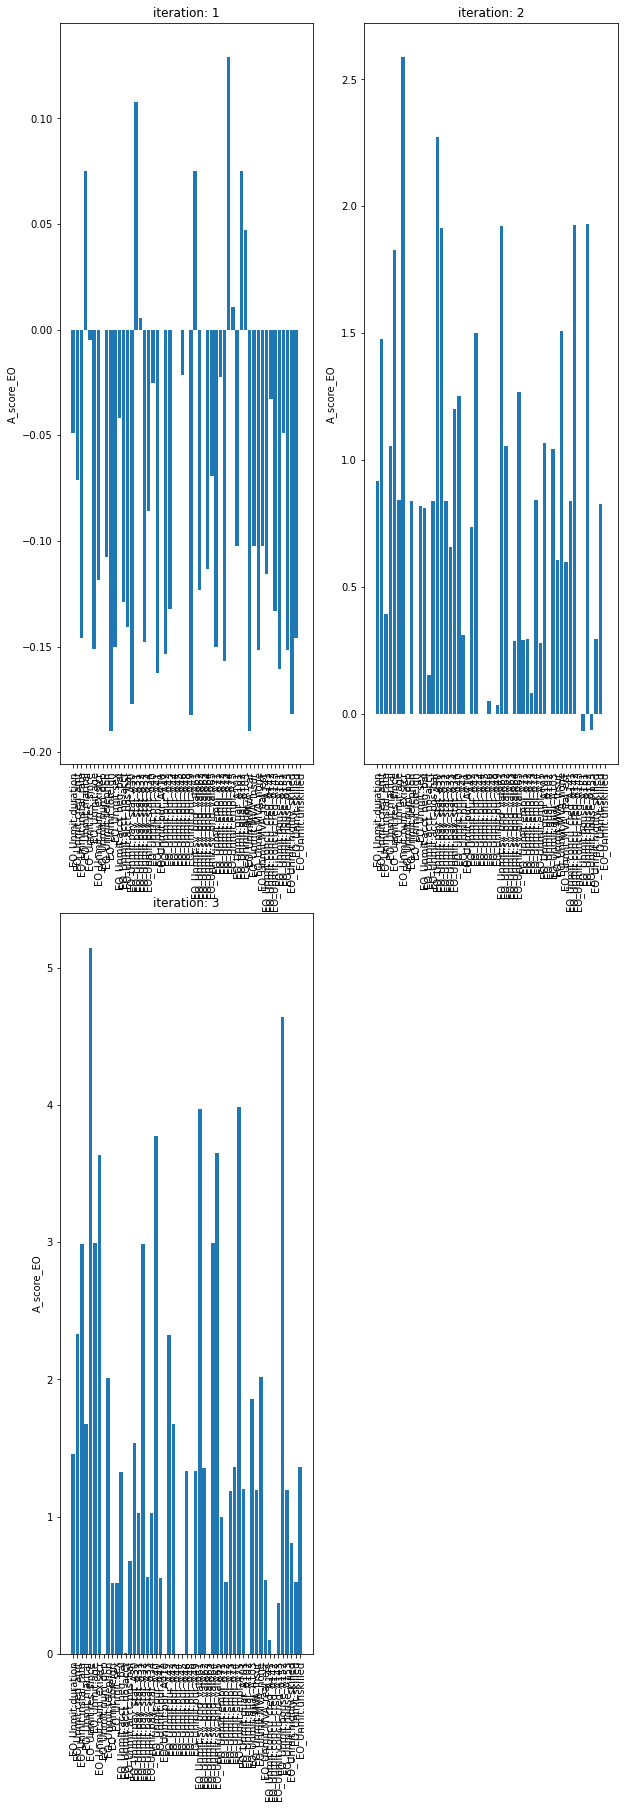

In [40]:
outer_key = info_dict.keys()
outer_val = list(info_dict.values())

plt.figure(figsize=(10,30))
for i in range(0,len(outer_val)):
    inner_keys = outer_val[i].keys()
    inner_vals = outer_val[i].values()
    plt.subplot(round(len(outer_val)/2),2,i+1)
    plt.title('iteration: '+str(i+1))
    plt.ylabel('A_score_EO')
    plt.bar(inner_keys, inner_vals)
    plt.xticks(rotation = 90);

In [41]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 
if dataType == "unmitigated":
    print("AUC vals (Unmitigated data in Ascore framework)")
    print()
    print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
if dataType == "threshold_opt":
    print("AUC vals (Threshold Opt data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
if dataType == "Exponentiated_grad":
    print("AUC vals (Exponentiated Grd data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
print("******************************")

******************************
AUC vals (Unmitigated data in Ascore framework)

EO_Unmit:allFeat            0.735
EO_Unmit:duration           0.715
EO_Unmit:cred_amt           0.735
EO_Unmit:instal_rate        0.745
EO_Unmit:marital            0.730
EO_Unmit:res_since          0.735
EO_Unmit:age                0.735
EO_Unmit:num_existcr        0.755
EO_Unmit:num_dep            0.735
EO_Unmit:telephon           0.740
EO_Unmit:foreign            0.750
EO_Unmit:sex                0.750
EO_Unmit:acct_neg_bal       0.760
EO_Unmit:acct_no_acct       0.750
EO_Unmit:acct_pos_bal       0.745
EO_Unmit:pay_stat_A30       0.735
EO_Unmit:pay_stat_A31       0.710
EO_Unmit:pay_stat_A32       0.740
EO_Unmit:pay_stat_A33       0.725
EO_Unmit:pay_stat_A34       0.710
EO_Unmit:pur_A40            0.750
EO_Unmit:pur_A41            0.730
EO_Unmit:pur_A410           0.735
EO_Unmit:pur_A42            0.740
EO_Unmit:pur_A43            0.725
EO_Unmit:pur_A44            0.735
EO_Unmit:pur_A45            0.735
EO

In [42]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 

if constraint == "equalized_odds":
    if dataType == "unmitigated" :
        print("Eq. Odds vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[4,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("Eq. Odds vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("Eq. Odds vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************")
    
if constraint == "demographic_parity":
    if dataType == "unmitigated" :
        print("DP vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[1,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("DP vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("DP vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************") 


******************************
Eq. Odds vals (Unmitigated data in Ascore framework)

EO_Unmit:allFeat            0.007541
EO_Unmit:duration           0.058824
EO_Unmit:cred_amt           0.091036
EO_Unmit:instal_rate        0.114846
EO_Unmit:marital            0.067227
EO_Unmit:res_since          0.191877
EO_Unmit:age                0.114846
EO_Unmit:num_existcr        0.138655
EO_Unmit:num_dep            0.007541
EO_Unmit:telephon           0.079832
EO_Unmit:foreign            0.026611
EO_Unmit:sex                0.026611
EO_Unmit:acct_neg_bal       0.056022
EO_Unmit:acct_no_acct       0.008403
EO_Unmit:acct_pos_bal       0.032213
EO_Unmit:pay_stat_A30       0.062594
EO_Unmit:pay_stat_A31       0.043417
EO_Unmit:pay_stat_A32       0.114846
EO_Unmit:pay_stat_A33       0.027149
EO_Unmit:pay_stat_A34       0.043417
EO_Unmit:pur_A40            0.143288
EO_Unmit:pur_A41            0.027149
EO_Unmit:pur_A410           0.007541
EO_Unmit:pur_A42            0.091036
EO_Unmit:pur_A43           

In [43]:
outer_val = list(info_dict.values())
print(outer_val[0].keys())

dict_keys(['EO_Unmit:duration', 'EO_Unmit:cred_amt', 'EO_Unmit:instal_rate', 'EO_Unmit:marital', 'EO_Unmit:res_since', 'EO_Unmit:age', 'EO_Unmit:num_existcr', 'EO_Unmit:num_dep', 'EO_Unmit:telephon', 'EO_Unmit:foreign', 'EO_Unmit:sex', 'EO_Unmit:acct_neg_bal', 'EO_Unmit:acct_no_acct', 'EO_Unmit:acct_pos_bal', 'EO_Unmit:pay_stat_A30', 'EO_Unmit:pay_stat_A31', 'EO_Unmit:pay_stat_A32', 'EO_Unmit:pay_stat_A33', 'EO_Unmit:pay_stat_A34', 'EO_Unmit:pur_A40', 'EO_Unmit:pur_A41', 'EO_Unmit:pur_A410', 'EO_Unmit:pur_A42', 'EO_Unmit:pur_A43', 'EO_Unmit:pur_A44', 'EO_Unmit:pur_A45', 'EO_Unmit:pur_A46', 'EO_Unmit:pur_A48', 'EO_Unmit:pur_A49', 'EO_Unmit:sv_bnd_valA61', 'EO_Unmit:sv_bnd_valA62', 'EO_Unmit:sv_bnd_valA63', 'EO_Unmit:sv_bnd_valA64', 'EO_Unmit:sv_bnd_valA65', 'EO_Unmit:empl_A71', 'EO_Unmit:empl_A72', 'EO_Unmit:empl_A73', 'EO_Unmit:empl_A74', 'EO_Unmit:empl_A75', 'EO_Unmit:guar_A101', 'EO_Unmit:guar_A102', 'EO_Unmit:guar_A103', 'EO_Unmit:MVA_car', 'EO_Unmit:MVA_insur', 'EO_Unmit:MVA_none',

### trying random things

In [44]:
Ascore_df.index
checker = Ascore_df.index[Ascore_df.index>=0.2]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

In [45]:
dummy = "EO_Unmit:Age"

In [46]:
dummy[0:2]+"_ThrOpt:"+dummy[9:]

'EO_ThrOpt:Age'

In [47]:
checker = valid_features

In [48]:
np.all(checker == valid_features)

True